# RF Pulse Design

RF pulse design in the small-tip regime (< 60-degrees) can utilize the Fourier Transform, while larger flip angle designs such as 90 and 180-degree pulses benefit from advanced techniques like the Shinnar-Le Roux (SLR) algorithm.

## Learning Goals

1. Manipulate MRI sequence parameters to improve performance
    * Understand how to design RF pulses

## General Considerations - Pulse Duration and Ripple

RF pulse designs should address the limited available pulse duration and, for large flip angle designs (e.g. 90 and 180 degrees) the non-linearities in the Bloch equation.  

Limited available durations are addressed, in small flip angle pulses, by using windowing functions along with sinc pulses.  The end result are windowed sinc pulses, which have less ringing in the coil profile as illustrated below.

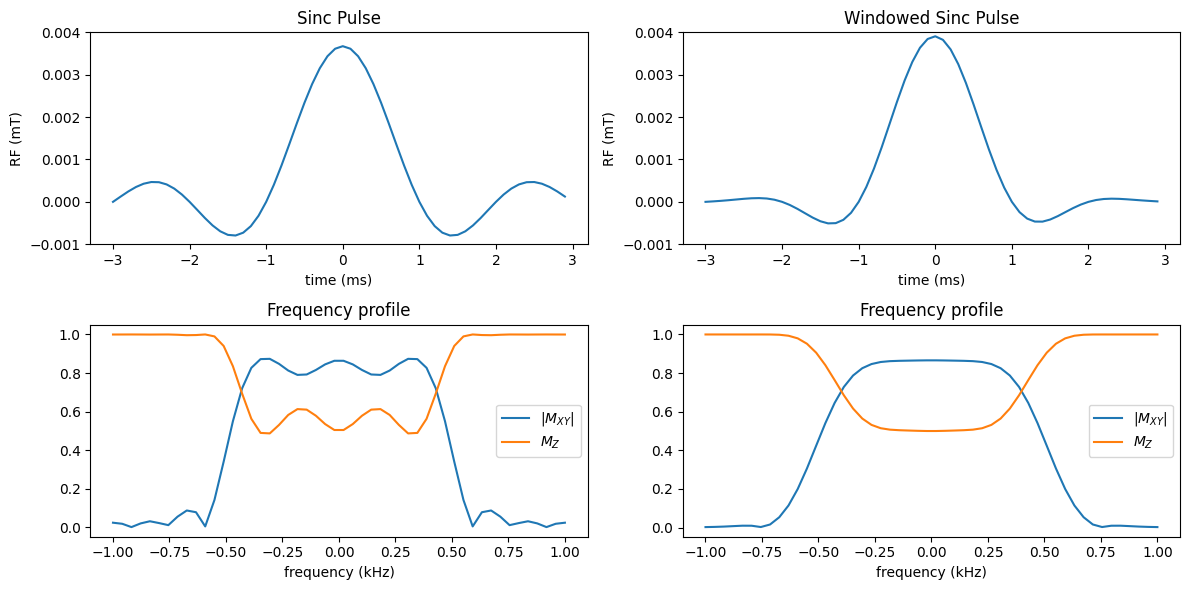

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../Physics/')  
from bloch_rotate import bloch_rotate

# parameters
gammabar = 42.58  # kHz/mT
M0 = 1.0
M_equilibrium = np.array([0.0, 0.0, M0])
dt = 0.1  # ms
flip = 60.0

tmax = 6.0
N = int(tmax / dt)
t = (np.arange(-N//2, N//2) * dt).astype(float)

BW = 1.0  # kHz
df = np.linspace(-BW, BW)

# side-by-side plots for Sinc and Windowed Sinc pulses
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Sinc pulse
RF_sinc = np.sinc(t)
RF_sinc = (flip * np.pi / 180.0) * RF_sinc / np.sum(RF_sinc) / (2 * np.pi * gammabar * dt)

M_sinc = np.tile(M_equilibrium[:, None], (1, len(df)))
for n_idx in range(len(t)):
    for f_idx in range(len(df)):
        B = [np.real(RF_sinc[n_idx]), np.imag(RF_sinc[n_idx]), df[f_idx] / gammabar]
        M_sinc[:, f_idx] = bloch_rotate(M_sinc[:, f_idx], dt, B)

axs[0, 0].plot(t, RF_sinc)
axs[0, 0].set_xlabel('time (ms)')
axs[0, 0].set_ylabel('RF (mT)')
axs[0, 0].set_ylim(-0.001, 0.004)
axs[0, 0].set_title('Sinc Pulse')

axs[1, 0].plot(df, np.sqrt(M_sinc[0, :]**2 + M_sinc[1, :]**2), label=r'$|M_{XY}|$')
axs[1, 0].plot(df, M_sinc[2, :], label=r'$M_{Z}$')
axs[1, 0].set_title('Frequency profile')
axs[1, 0].set_xlabel('frequency (kHz)')
axs[1, 0].legend()

# Windowed Sinc Pulse
RF_win = np.hamming(N) * np.sinc(t)
RF_win = (flip * np.pi / 180.0) * RF_win / np.sum(RF_win) / (2 * np.pi * gammabar * dt)

M_win = np.tile(M_equilibrium[:, None], (1, len(df)))
for n_idx in range(len(t)):
    for f_idx in range(len(df)):
        B = [np.real(RF_win[n_idx]), np.imag(RF_win[n_idx]), df[f_idx] / gammabar]
        M_win[:, f_idx] = bloch_rotate(M_win[:, f_idx], dt, B)

axs[0, 1].plot(t, RF_win)
axs[0, 1].set_xlabel('time (ms)')
axs[0, 1].set_ylabel('RF (mT)')
axs[0, 1].set_ylim(-0.001, 0.004)
axs[0, 1].set_title('Windowed Sinc Pulse')

axs[1, 1].plot(df, np.sqrt(M_win[0, :]**2 + M_win[1, :]**2), label=r'$|M_{XY}|$')
axs[1, 1].plot(df, M_win[2, :], label=r'$M_{Z}$')
axs[1, 1].set_title('Frequency profile')
axs[1, 1].set_xlabel('frequency (kHz)')
axs[1, 1].legend()

fig.tight_layout()
plt.show()

## Time-bandwidth Product and Pulse Selectivity

Arguably the most important RF pulse design parameter is the "time-bandwidth" product.  As the name implies, this is the pulse duration (time) times the pulse bandwidth

$$ TBW = T_{rf} \times BW_{rf} $$

A given RF pulse shape has an associated TBW, and this shape can be stretched or shrunk in time to modulate the resulting bandwidth.

The key feature of the TBW is that it controls the _pulse selectivity_, that is how sharp the pulse profile is, or, in other words, how quickly the profile goes from the desired flip angle to zero flip angle.

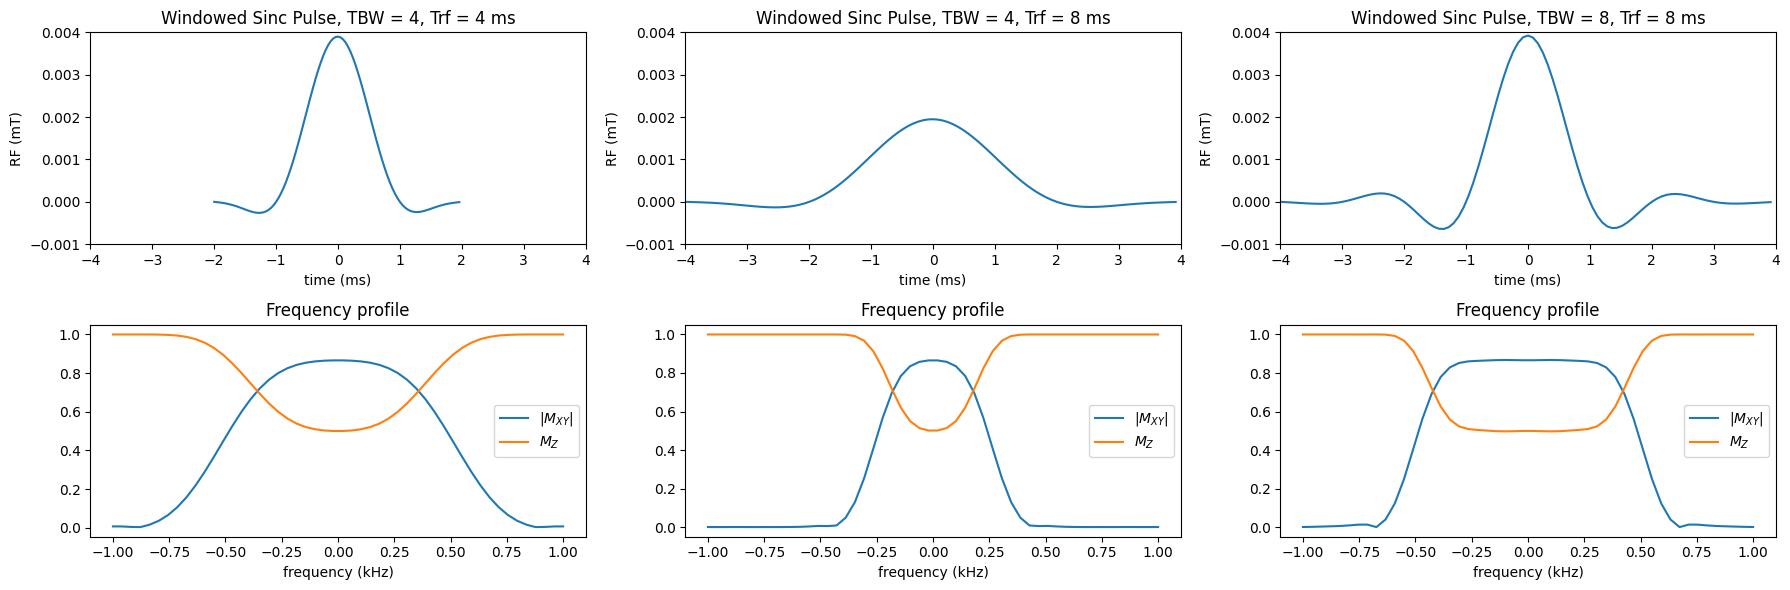

In [21]:
# Convert MATLAB cell to Python and place the three pulse panels side-by-side
# Uses existing variables: gammabar, flip, df, M_equilibrium, bloch_rotate

cases = [
    (4, 4, 'TBW = 4, Trf = 4 ms'),
    (4, 8, 'TBW = 4, Trf = 8 ms'),
    (8, 8, 'TBW = 8, Trf = 8 ms'),
]

Np = 100  # sample points for pulse shape
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

for i, (TBW, Trf, title) in enumerate(cases):
    IN = np.arange(-Np/2, Np/2) / Np
    RF_shape = np.hamming(Np) * np.sinc(IN * TBW)      # windowed sinc
    t_pulse = IN * Trf                                  # time axis (ms)
    dt_pulse = Trf / Np

    RF = (flip * np.pi / 180.0) * RF_shape / np.sum(RF_shape) / (2 * np.pi * gammabar * dt_pulse)

    M = np.tile(M_equilibrium[:, None], (1, len(df)))
    for n_idx in range(len(t_pulse)):
        for f_idx in range(len(df)):
            B_field = [np.real(RF[n_idx]), np.imag(RF[n_idx]), df[f_idx] / gammabar]
            M[:, f_idx] = bloch_rotate(M[:, f_idx], dt_pulse, B_field)

    axs[0, i].plot(t_pulse, RF)
    axs[0, i].set_xlim(-4, 4)
    axs[0, i].set_xlabel('time (ms)')
    axs[0, i].set_ylabel('RF (mT)')
    axs[0, i].set_ylim(-0.001, 0.004)
    axs[0, i].set_title(f'Windowed Sinc Pulse, {title}')

    axs[1, i].plot(df, np.sqrt(M[0, :]**2 + M[1, :]**2), label=r'$|M_{XY}|$')
    axs[1, i].plot(df, M[2, :], label=r'$M_{Z}$')
    axs[1, i].set_xlabel('frequency (kHz)')
    axs[1, i].set_title('Frequency profile')
    axs[1, i].legend()

fig.tight_layout()
plt.show()


Notice that the higher TBW pulse has much sharper frequency profile for the same pulse duration!  (But also higher peak power.)

## High flip angle pulse design


For small flip angles, the frequency profile of a RF pulse is approximately given by the Fourier Transform.  However, non-linearities in the Bloch equation cause this approximation to break down for large flip angles, as shown below by the resulting "ripples" in the frequency profile when the flip angle of the windowed.


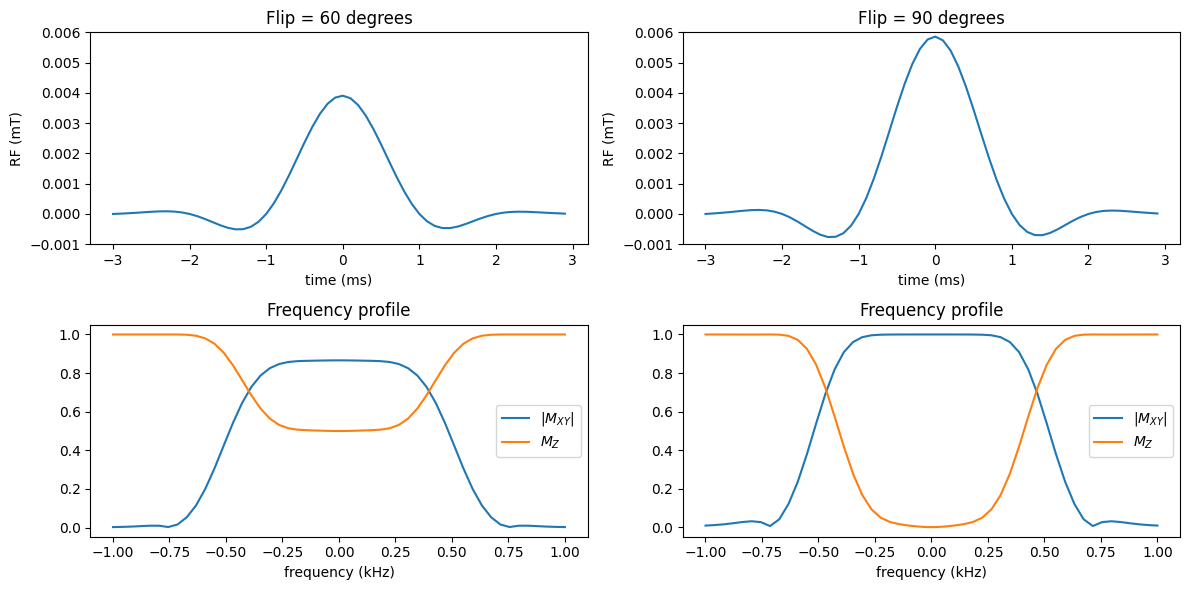

In [12]:
# small tip vs large tip (converted from MATLAB)
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# common RF shape (windowed sinc)
RF_shape = np.hamming(N) * np.sinc(t)

for col, flip_angle in enumerate([60, 90]):
    RF = (flip_angle * np.pi / 180.0) * RF_shape / np.sum(RF_shape) / (2 * np.pi * gammabar * dt)

    M = np.tile(M_equilibrium[:, None], (1, len(df)))
    for n_idx in range(len(t)):
        for f_idx in range(len(df)):
            B_field = [np.real(RF[n_idx]), np.imag(RF[n_idx]), df[f_idx] / gammabar]
            M[:, f_idx] = bloch_rotate(M[:, f_idx], dt, B_field)

    # top row: pulse in time
    axs[0, col].plot(t, RF)
    axs[0, col].set_xlabel('time (ms)')
    axs[0, col].set_ylim(-0.001, 0.006)
    axs[0, col].set_ylabel('RF (mT)')
    axs[0, col].set_title(f'Flip = {flip_angle} degrees')

    # bottom row: frequency profile
    axs[1, col].plot(df, np.sqrt(M[0, :]**2 + M[1, :]**2), label=r'$|M_{XY}|$')
    axs[1, col].plot(df, M[2, :], label=r'$M_{Z}$')
    axs[1, col].set_xlabel('frequency (kHz)')
    axs[1, col].set_title('Frequency profile')
    axs[1, col].legend()

fig.tight_layout()
plt.show()


Note that with Fourier Transform based design small ripples that appear outside the desired slice.

The solution is to use a more sophisticated pulse design that takes into account these non-linearities, such as the Shinnar-Le Roux (SLR) transform.

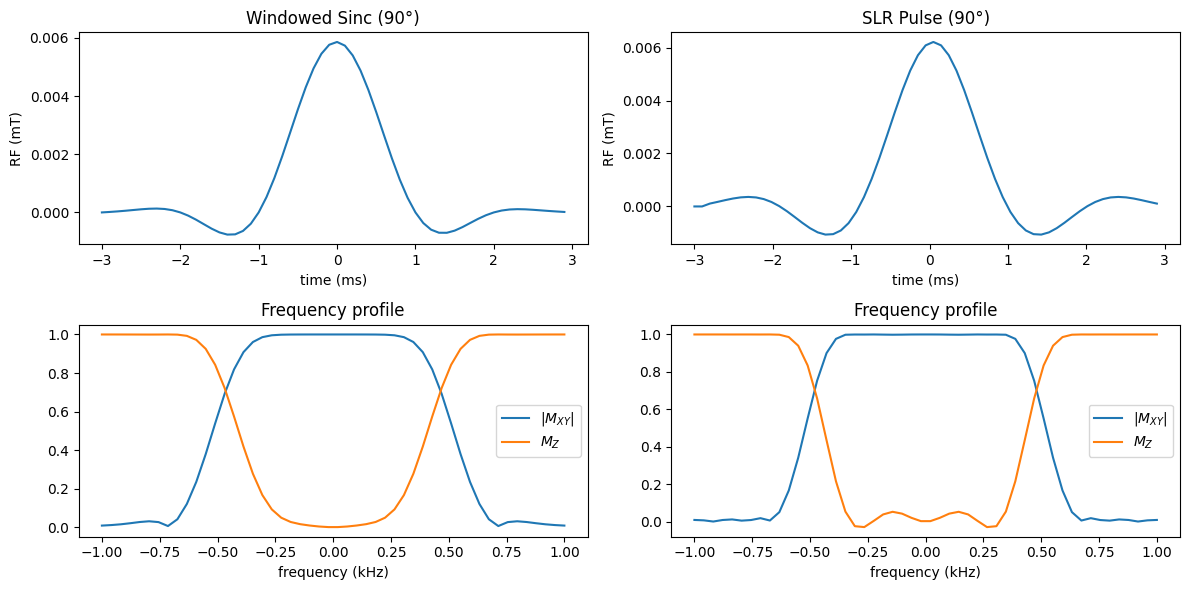

In [22]:
# Large-tip (90 deg) pulse comparison: Windowed Sinc vs SLR (converted from MATLAB)
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# use existing variables: gammabar, M_equilibrium, dt, t, N, df, bloch_rotate
flip = 90.0

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# --- Windowed sinc pulse (recreate the shape and scale for 90 deg) ---
RF_wsinc = np.hamming(N) * np.sinc(t)            # windowed sinc shape
RF_win90 = (flip * np.pi / 180.0) * RF_wsinc / np.sum(RF_wsinc) / (2 * np.pi * gammabar * dt)

# simulate Bloch for windowed sinc
M_win = np.tile(M_equilibrium[:, None], (1, len(df)))
for n_idx in range(len(RF_win90)):
    for f_idx in range(len(df)):
        B_field = [np.real(RF_win90[n_idx]), np.imag(RF_win90[n_idx]), df[f_idx] / gammabar]
        M_win[:, f_idx] = bloch_rotate(M_win[:, f_idx], dt, B_field)

# top-left: RF waveform, bottom-left: frequency profile
axs[0, 0].plot(t, RF_win90)
axs[0, 0].set_xlabel('time (ms)')
axs[0, 0].set_ylabel('RF (mT)')
axs[0, 0].set_title('Windowed Sinc (90°)')

axs[1, 0].plot(df, np.sqrt(M_win[0, :]**2 + M_win[1, :]**2), label=r'$|M_{XY}|$')
axs[1, 0].plot(df, M_win[2, :], label=r'$M_{Z}$')
axs[1, 0].set_xlabel('frequency (kHz)')
axs[1, 0].set_title('Frequency profile')
axs[1, 0].legend()

# --- SLR pulse: try to load .mat, fall back to existing RF variable if load fails ---
# SLR pulse created with dzrf() in MATLAB rf_tools using
#   RF = dzrf(N-1, tmax*1, 'ex');
RF_slr_raw = None
try:
    mat = loadmat('../RF Pulses/RFpulse_excitation_tbw6_SLR.mat')
    # pick the first ndarray-like variable that isn't metadata
    for k, v in mat.items():
        if not k.startswith('__') and isinstance(v, np.ndarray) and v.size > 0:
            RF_slr_raw = v
            break
    if RF_slr_raw is None:
        raise RuntimeError('no candidate RF array found in .mat')
    # flatten and ensure 1D
    RF_slr_raw = RF_slr_raw.flatten()
except Exception:
    # fallback: use existing RF variable in the notebook if available
    try:
        RF_slr_raw = RF.flatten()  # use preexisting RF if present
    except Exception:
        raise

# MATLAB code prepended a zero: [0, RF]
RF_slr90 = (flip * np.pi / 180.0) * np.concatenate(([0.0], RF_slr_raw)) / np.sum(np.concatenate(([0.0], RF_slr_raw))) / (2 * np.pi * gammabar * dt)

# make time axis for SLR: length must match RF_slr90; reuse t if lengths match, otherwise build symmetric axis
if len(RF_slr90) == len(t):
    t_slr = t
else:
    t_slr = np.linspace(t[0], t[-1], len(RF_slr90))

# simulate Bloch for SLR
M_slr = np.tile(M_equilibrium[:, None], (1, len(df)))
for n_idx in range(len(RF_slr90)):
    for f_idx in range(len(df)):
        B_field = [np.real(RF_slr90[n_idx]), np.imag(RF_slr90[n_idx]), df[f_idx] / gammabar]
        M_slr[:, f_idx] = bloch_rotate(M_slr[:, f_idx], dt, B_field)

# top-right: SLR RF, bottom-right: frequency profile
axs[0, 1].plot(t_slr, np.real(RF_slr90))
axs[0, 1].set_xlabel('time (ms)')
axs[0, 1].set_ylabel('RF (mT)')
axs[0, 1].set_title('SLR Pulse (90°)')

axs[1, 1].plot(df, np.sqrt(M_slr[0, :]**2 + M_slr[1, :]**2), label=r'$|M_{XY}|$')
axs[1, 1].plot(df, M_slr[2, :], label=r'$M_{Z}$')
axs[1, 1].set_xlabel('frequency (kHz)')
axs[1, 1].set_title('Frequency profile')
axs[1, 1].legend()

fig.tight_layout()
plt.show()


Note that now the ripples in the $M_{XY}$ profile are now removed!  (There is some increased ripple in $M_Z$, but this isn't an issue for excitation pulses).  The RF pulses themselves are only subtly different.

The degradation of the slice (frequency) profile of sinc-pulses becomes substantial with a 180-degree flip angle inversion pulse:

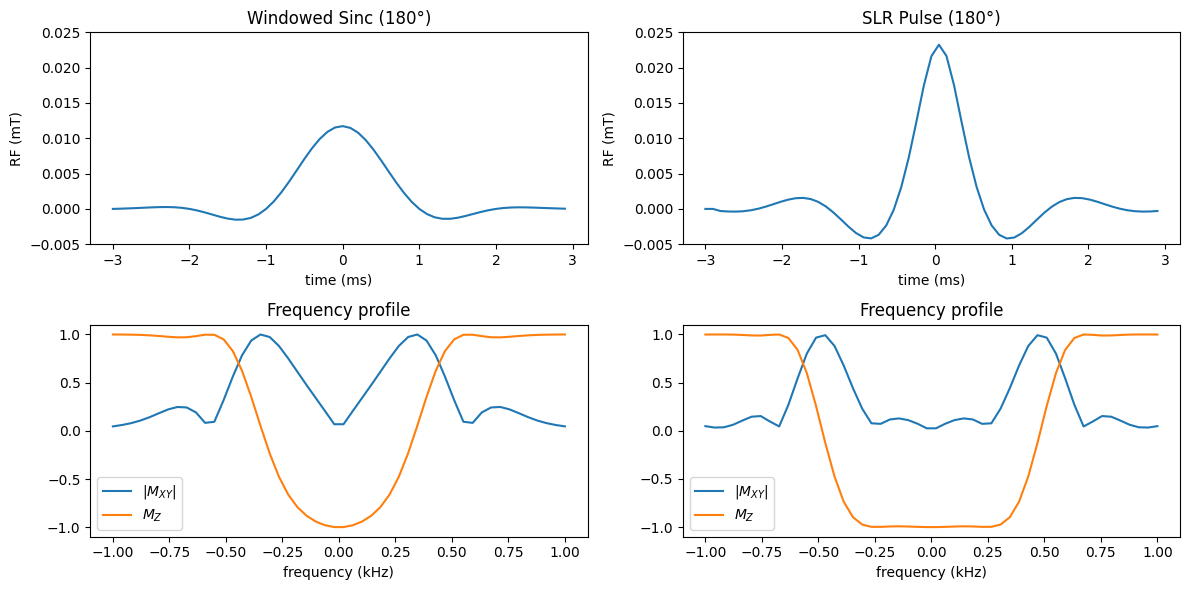

In [23]:
# Inversion (large-tip) pulses (converted from MATLAB)
# uses existing: gammabar, M_equilibrium, dt, t, N, df, bloch_rotate

flip = 180.0

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# -- Windowed Sinc Pulse --
RF_shape = np.hamming(N) * np.sinc(t)
RF_win_inv = (flip * np.pi / 180.0) * RF_shape / np.sum(RF_shape) / (2 * np.pi * gammabar * dt)

M_win_inv = np.tile(M_equilibrium[:, None], (1, len(df)))
for n_idx in range(len(RF_win_inv)):
    for f_idx in range(len(df)):
        B_field = [np.real(RF_win_inv[n_idx]), np.imag(RF_win_inv[n_idx]), df[f_idx] / gammabar]
        M_win_inv[:, f_idx] = bloch_rotate(M_win_inv[:, f_idx], dt, B_field)

# top-left: RF, bottom-left: frequency profile
axs[0, 0].plot(t, RF_win_inv)
axs[0, 0].set_xlabel('time (ms)')
axs[0, 0].set_ylabel('RF (mT)')
axs[0, 0].set_ylim(-0.005, 0.025)
axs[0, 0].set_title('Windowed Sinc (180°)')

axs[1, 0].plot(df, np.sqrt(M_win_inv[0, :]**2 + M_win_inv[1, :]**2), label=r'$|M_{XY}|$')
axs[1, 0].plot(df, M_win_inv[2, :], label=r'$M_{Z}$')
axs[1, 0].set_xlabel('frequency (kHz)')
axs[1, 0].set_title('Frequency profile')
axs[1, 0].legend()

# -- SLR Pulse: try to load .mat, fall back to existing RF variable if load fails --
# SLR pulse created with dzrf() in MATLAB rf_tools using
#   RF = dzrf(N-1, tmax*1, 'inv');
RF_slr_raw = None
try:
    mat = loadmat('../RF Pulses/RFpulse_inversion_tbw6_SLR.mat')
    for k, v in mat.items():
        if not k.startswith('__') and isinstance(v, np.ndarray) and v.size > 0:
            RF_slr_raw = v
            break
    if RF_slr_raw is None:
        raise RuntimeError('no candidate RF array found in .mat')
    RF_slr_raw = RF_slr_raw.flatten()
except Exception:
    # fallback: use existing RF (if present) / RF_slr_raw from workspace
    try:
        RF_slr_raw = RF.flatten()
    except Exception:
        raise

# MATLAB prepended zero in original script: [0, RF]
RF_slr_inv = (flip * np.pi / 180.0) * np.concatenate(([0.0], RF_slr_raw)) / np.sum(np.concatenate(([0.0], RF_slr_raw))) / (2 * np.pi * gammabar * dt)

# time axis for SLR
if len(RF_slr_inv) == len(t):
    t_slr = t
else:
    t_slr = np.linspace(t[0], t[-1], len(RF_slr_inv))

M_slr_inv = np.tile(M_equilibrium[:, None], (1, len(df)))
for n_idx in range(len(RF_slr_inv)):
    for f_idx in range(len(df)):
        B_field = [np.real(RF_slr_inv[n_idx]), np.imag(RF_slr_inv[n_idx]), df[f_idx] / gammabar]
        M_slr_inv[:, f_idx] = bloch_rotate(M_slr_inv[:, f_idx], dt, B_field)

# top-right: SLR RF, bottom-right: frequency profile
axs[0, 1].plot(t_slr, np.real(RF_slr_inv))
axs[0, 1].set_xlabel('time (ms)')
axs[0, 1].set_ylim(-0.005, 0.025)
axs[0, 1].set_ylabel('RF (mT)')
axs[0, 1].set_title('SLR Pulse (180°)')

axs[1, 1].plot(df, np.sqrt(M_slr_inv[0, :]**2 + M_slr_inv[1, :]**2), label=r'$|M_{XY}|$')
axs[1, 1].plot(df, M_slr_inv[2, :], label=r'$M_{Z}$')
axs[1, 1].set_xlabel('frequency (kHz)')
axs[1, 1].set_title('Frequency profile')
axs[1, 1].legend()

fig.tight_layout()
plt.show()


Note that the inversion profile $M_Z$ is much more selective, in other words more like a rectangular function, with the SLR pulse design.    The SLR RF pulse is now noticeably different from a windowed sinc.